In [2]:
# Challenge: https://www.kaggle.com/c/yelp-restaurant-photo-classification
from keras.models import Sequential, Graph
from keras.layers.core import Flatten, Dense, Dropout, Activation
from keras.layers.convolutional import Convolution1D, Convolution2D, MaxPooling2D, ZeroPadding2D
from keras.utils.visualize_util import plot, to_graph
from keras.utils import np_utils, generic_utils
from keras.optimizers import SGD
from IPython.display import SVG
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
from scipy import misc
import IPython

%matplotlib inline
plt.rcParams['figure.figsize'] = (20.0, 20.0) # set default size of plots

In [3]:
#GPU test
from theano import function, config, shared, tensor, sandbox
import numpy
import time

vlen = 10 * 30 * 768  # 10 x #cores x # threads per core
iters = 1000

rng = numpy.random.RandomState(22)
x = shared(numpy.asarray(rng.rand(vlen), config.floatX))
f = function([], tensor.exp(x))
print(f.maker.fgraph.toposort())
t0 = time.time()
for i in range(iters):
    r = f()
t1 = time.time()
print("Looping %d times took %f seconds" % (iters, t1 - t0))
print("Result is %s" % (r,))
if numpy.any([isinstance(x.op, tensor.Elemwise) and
              ('Gpu' not in type(x.op).__name__)
              for x in f.maker.fgraph.toposort()]):
    print('Used the cpu')
else:
    print('Used the gpu')


/Users/yrevar/virtualenvs/keras/lib/python2.7/site-packages/theano/tensor/signal/downsample.py:6: UserWarning: downsample module has been moved to the theano.tensor.signal.pool module.
  "downsample module has been moved to the theano.tensor.signal.pool module.")


[Elemwise{exp,no_inplace}(<TensorType(float32, vector)>)]
Looping 1000 times took 1.898220 seconds
Result is [ 1.23178029  1.61879337  1.52278066 ...,  2.20771813  2.29967761
  1.62323284]
Used the cpu


## Read input data

In [17]:
DATA_DIR = "../input"
# %ls $DATA_DIR

TRAIN_PHOTOS_TO_BIZID_CSV_PATH = os.path.join(DATA_DIR,'train_photo_to_biz_ids.csv')
TRAIN_BIZID_TO_ATTRIBS_CSV_PATH = os.path.join(DATA_DIR,'train.csv')
TRAIN_PHOTOS_PATH = os.path.join(DATA_DIR,'train_photos')

# Table: Photos (many) -> BIZ ID (one)
train_photo_to_biz_id_tbl = pd.read_csv(TRAIN_PHOTOS_TO_BIZID_CSV_PATH)
# Table: BIZ ID (one) -> Attribs (many)
train_biz_id_attribs_tbl = pd.read_csv(TRAIN_BIZID_TO_ATTRIBS_CSV_PATH)
train_biz_id_attribs_tbl = train_biz_id_attribs_tbl.dropna()
train_biz_id_attribs_tbl = train_biz_id_attribs_tbl.drop_duplicates()

# drop entries with no attribute data
train_photo_to_biz_id_tbl['has_attribs'] \
        = train_photo_to_biz_id_tbl['business_id'].apply(
                lambda x: True if x in train_biz_id_attribs_tbl.business_id.values else False)
train_photo_to_biz_id_tbl = train_photo_to_biz_id_tbl[train_photo_to_biz_id_tbl['has_attribs'] == True]
train_photo_to_biz_id_tbl = train_photo_to_biz_id_tbl.drop('has_attribs', axis=1)

# Dictionary: BIZ ID (one) -> Photos (many)
train_biz_id_to_photos = {k: g["photo_id"].tolist() for k,g in train_photo_to_biz_id_tbl.groupby("business_id")}

# Dictionary:  Photos (many) -> BIZ ID (one)
train_photos_to_biz_id = {k: g["business_id"].values[0] for k,g in train_photo_to_biz_id_tbl.groupby("photo_id")}

restaurant_attributes = {0: "good_for_lunch",
1: "good_for_dinner",
2: "takes_reservations",
3: "outdoor_seating",
4: "restaurant_is_expensive",
5: "has_alcohol",
6: "has_table_service",
7: "ambience_is_classy",
8: "good_for_kids",}

# Separate column for each class
for attrib_key,attrib in restaurant_attributes.iteritems():
    train_biz_id_attribs_tbl[attrib] = train_biz_id_attribs_tbl['labels'].str.contains(str(attrib_key))

def get_business_attribs(biz_id):
    return train_biz_id_attribs_tbl[train_biz_id_attribs_tbl['business_id'] == biz_id]['labels'].tolist()[0].split(" ")

train_biz_id_to_attribs = {biz_id: get_business_attribs(biz_id) for biz_id in train_biz_id_attribs_tbl['business_id']}
train_biz_id_attribs_tbl.head()

,business_id,labels,good_for_lunch,good_for_dinner,takes_reservations,outdoor_seating,restaurant_is_expensive,has_alcohol,has_table_service,ambience_is_classy,good_for_kids
0,1000,1 2 3 4 5 6 7,False,True,True,True,True,True,True,True,False
1,1001,0 1 6 8,True,True,False,False,False,False,True,False,True
2,100,1 2 4 5 6 7,False,True,True,False,True,True,True,True,False
3,1006,1 2 4 5 6,False,True,True,False,True,True,True,False,False
4,1010,0 6 8,True,False,False,False,False,False,True,False,True


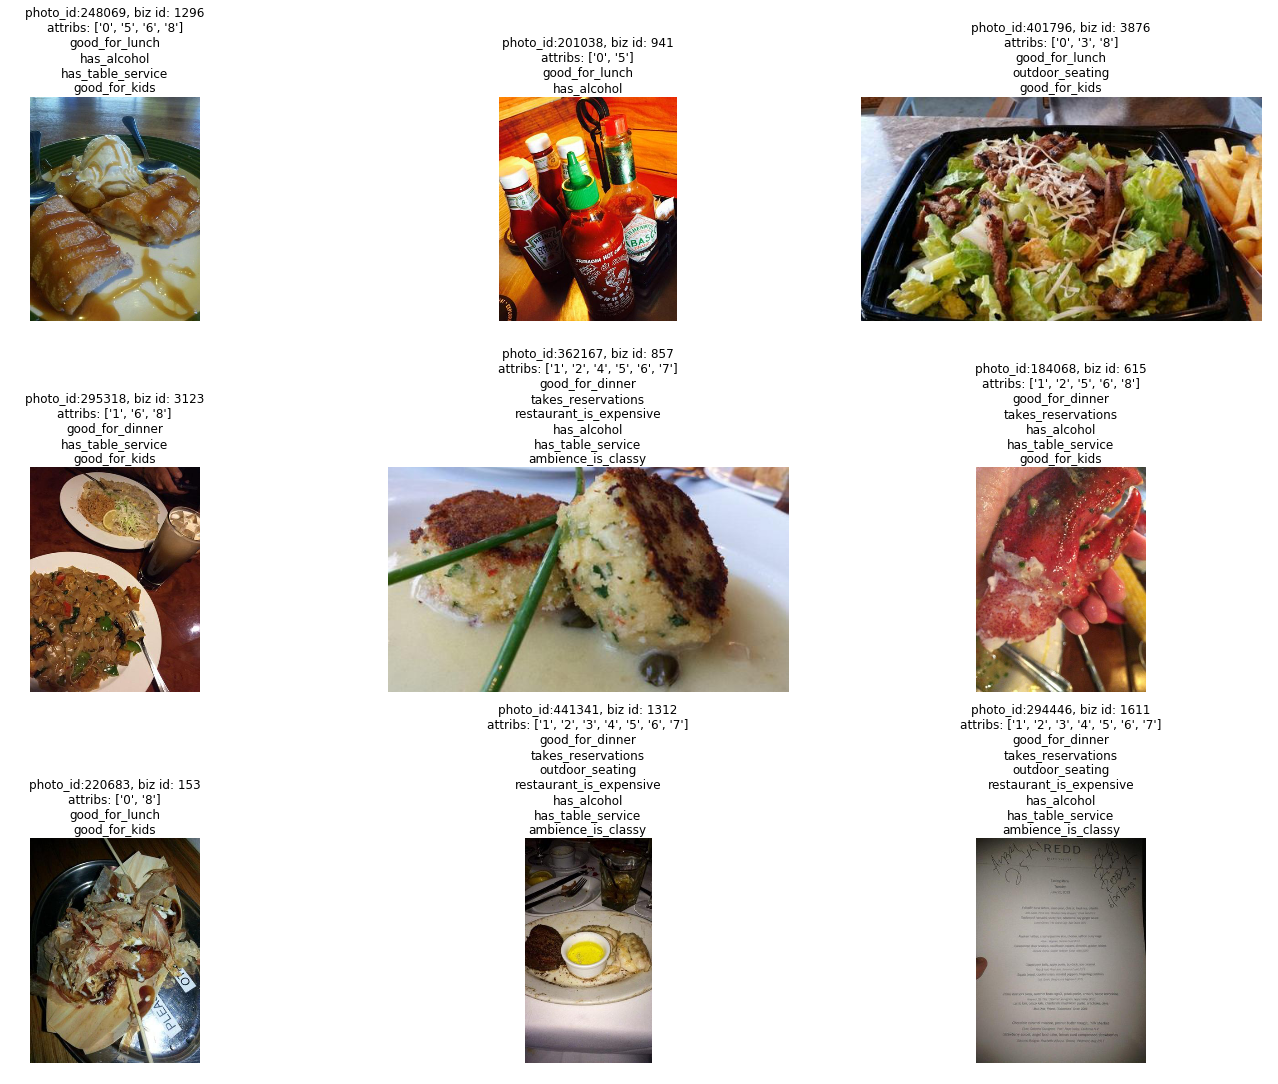

In [5]:
# sample
num_samples = 9
fig = plt.figure(figsize=(20,20))
rand_indices =  np.random.randint(0, len(train_photo_to_biz_id_tbl), num_samples)

for idx, (photo_id, biz_id) in enumerate(
                zip(train_photo_to_biz_id_tbl.photo_id[rand_indices].values,
                    train_photo_to_biz_id_tbl.business_id[rand_indices].values)):
    
    img = misc.imread(os.path.join(TRAIN_PHOTOS_PATH, str(photo_id)+".jpg"))
    attrib_ids = train_biz_id_to_attribs[biz_id]
    attrib_strs = [restaurant_attributes[int(i)] for i in attrib_ids]
    
    plt.subplot(np.sqrt(num_samples)+1, np.sqrt(num_samples), idx+1)
    plt.axis('off')
    plt.title("photo_id:" + str(photo_id) + ", biz id: " + str(biz_id) + "\n" + 
                      "attribs: " + str(attrib_ids) + "\n" + '\n'.join(attrib_strs))
    plt.imshow(img)
fig.tight_layout()

## Pre-process images

In [6]:
def readImage(img_id, vgg_compatible_input=True, preprocess=False, resize_to=(224, 224)):
    img = misc.imread(os.path.join('../input','train_photos', str(img_id)+".jpg"))
    resize_w, resize_h = resize_to
    
    if preprocess:
        img = misc.imresize(img, (resize_w, resize_h), interp="nearest").astype(np.float32)
        img[:,:,0] -= 103.939
        img[:,:,1] -= 116.779
        img[:,:,2] -= 123.68
        
    if vgg_compatible_input:
        img = img.transpose((2,0,1))
        img = np.expand_dims(img, axis=0)
        
    return img

## Visualize the input data

In [200]:
def sample_class_images(attrib_table, class_name, max_sample_biz=10, max_sample_photos_per_biz=10):
    has_class_biz_ids = attrib_table[attrib_table[class_name] == True]['business_id']
    # iterate over business with attrib class_name
    for i, biz_id in enumerate(has_class_biz_ids.to_dict().values()[:max_sample_biz]):
        # iterate over all photos of that particular business 
        for j in range(min(len(train_biz_id_to_photos[biz_id]), max_sample_photos_per_biz)):
            yield (i, biz_id, j)
            
def display_raw_images(attrib_table, class_name, max_biz = 10, max_biz_imgs = 10, vgg_compat = False, preprocess = False):
    for (i, biz_id, photo_idx) in sample_class_images(attrib_table, class_name, max_biz, max_biz_imgs):
        plt.subplot(max_biz+1, max_biz_imgs, i*max_biz+photo_idx+1)
        plt.axis("off")
        if vgg_compat:
            plt.imshow(
                readImage(
                    biz_id_to_photos[biz_id][photo_idx], vgg_compatible_input=True, preprocess=preprocess)[0].transpose(1,2,0))
        else:
            plt.imshow(
                readImage(
                    biz_id_to_photos[biz_id][photo_idx], vgg_compatible_input=False, preprocess=preprocess))

In [310]:
fig = plt.figure(1, figsize=(10,10))
st = fig.suptitle(class_name + " (raw images)", fontsize="x-large")
display_raw_images(train_biz_id_attribs_tbl, "outdoor_seating", 5, 5, vgg_compat = False, preprocess=False)

fig = plt.figure(2, figsize=(10,10))
st = fig.suptitle(class_name + " (vgg pre-processed images)", fontsize="x-large")
display_raw_images(train_biz_id_attribs_tbl, "outdoor_seating", 5, 5, vgg_compat = True, preprocess=True)

## Create training data

In [41]:
def generate_data(biz_id_to_attribs, photo_biz_id_tbl, size=16, channels=3, width=224, height=224, num_classes = 9, p_test = 0.2):
    
    num_test = int(size*p_test)
    num_train = size - num_test
    
    print "train size = ", num_train, ", test size = ", num_test
    
    X_train = np.zeros((num_train, channels, width, height))
    y_train = np.zeros((num_train, num_classes))

    if num_test:
        X_test = np.zeros((num_test, channels, width, height))
        y_test = np.zeros((num_test, num_classes))
    
    rand_idxs = np.arange(0, num_train+num_test) #np.random.randint(0, len(photo_biz_id_tbl), num_train+num_test)
    for idx, (img_id, biz_id) in enumerate(
                            zip(photo_biz_id_tbl.photo_id.values[rand_idxs], photo_biz_id_tbl.business_id.values[rand_idxs])):
        
        if idx < num_train:
            
#             print rand_idxs[idx], img_id, biz_id
            X_train[idx,:,:,:] = readImage(img_id, vgg_compatible_input=True, preprocess=True)
            y_train[idx] = np.array([(0,1)[str(i) in biz_id_to_attribs[biz_id]] for i in range(num_classes)])    
        elif num_test:
            
            X_test[idx-num_train,:,:,:] = readImage(img_id, vgg_compatible_input=True, preprocess=True)
            y_test[idx-num_train] = np.array([(0,1)[str(i) in biz_id_to_attribs[biz_id]] for i in range(num_classes)])
        else:
            assert(0)
            
    if num_test:
        return X_train, y_train, X_test, y_test
    
    return X_train, y_train

In [42]:
num_train_images = len(train_photos_to_biz_id)
print "total number of train images: ", num_train_images
X_train, y_train, X_test, y_test = generate_data(train_biz_id_to_attribs, train_photo_to_biz_id_tbl, 128, p_test=0.5)

total number of train images:  234545
train size =  64 , test size =  64


In [43]:
def VGG_16(weights_path=None):
    model = Sequential()
    model.add(ZeroPadding2D((1,1),input_shape=(3,224,224)))
    model.add(Convolution2D(64, 3, 3, activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(64, 3, 3, activation='relu'))
    model.add(MaxPooling2D((2,2), strides=(2,2)))

    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(128, 3, 3, activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(128, 3, 3, activation='relu'))
    model.add(MaxPooling2D((2,2), strides=(2,2)))

    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(256, 3, 3, activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(256, 3, 3, activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(256, 3, 3, activation='relu'))
    model.add(MaxPooling2D((2,2), strides=(2,2)))

    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(512, 3, 3, activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(512, 3, 3, activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(512, 3, 3, activation='relu'))
    model.add(MaxPooling2D((2,2), strides=(2,2)))

    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(512, 3, 3, activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(512, 3, 3, activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(512, 3, 3, activation='relu'))
    model.add(MaxPooling2D((2,2), strides=(2,2)))

    model.add(Flatten())
    model.add(Dense(4096, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(4096, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(1000, activation='softmax'))

    if weights_path:
        model.load_weights(weights_path)

    return model

In [44]:
vgg16_model = VGG_16('vgg16_weights.h5')

In [45]:
sgd = SGD(lr=0.1, decay=1e-6, momentum=0.9, nesterov=True)
vgg16_model.compile(optimizer=sgd, loss='categorical_crossentropy')

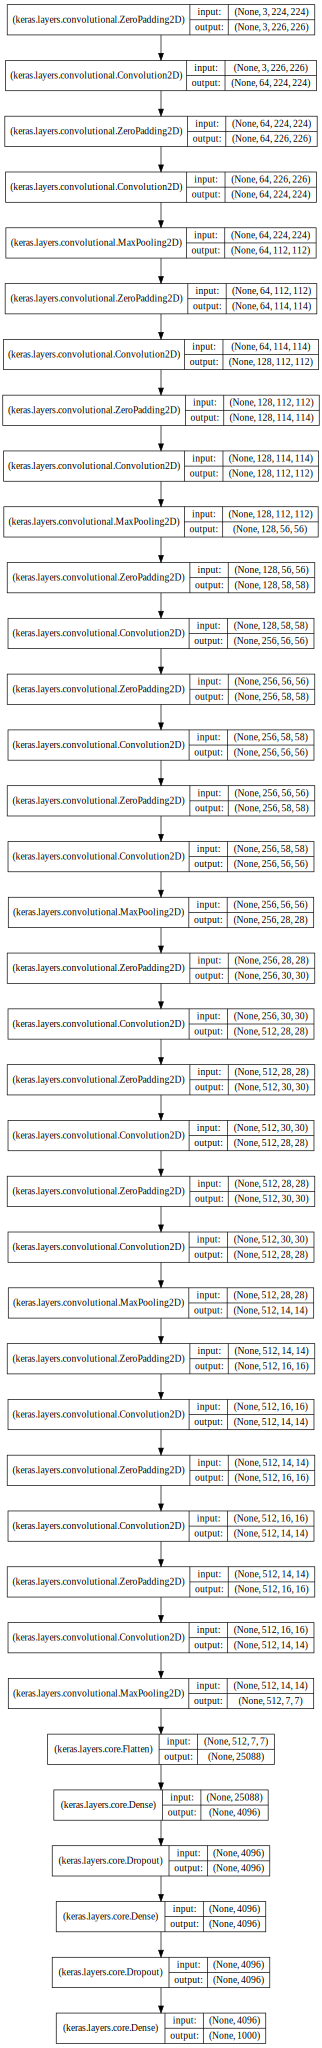

In [46]:
# To display model arch
SVG(to_graph(vgg16_model, show_shape=True).create(prog='dot', format='svg'))

In [47]:
def VGG_16_multilabel_gpu(weights_path=None):
    
    fc1_dim, fc2_dim, output_dim = 1024, 512, 1
    
    m = Graph()
    
    #64 repr
    m.add_input(name='input', input_shape=(3,224,224))
    m.add_node(ZeroPadding2D((1,1)), name="pad0", input="input")
    m.add_node(Convolution2D(64, 3, 3, activation='relu'), name="conv1", input="pad0")
    m.add_node(ZeroPadding2D((1,1)), name="pad1", input="conv1")
    m.add_node(Convolution2D(64, 3, 3, activation='relu'), name="conv2", input="pad1")
    m.add_node(MaxPooling2D((2,2), strides=(2,2)), name="maxp2", input="conv2")

    #128 repr
    m.add_node(ZeroPadding2D((1,1)), name="pad2", input="maxp2")
    m.add_node(Convolution2D(128, 3, 3, activation='relu'), name="conv3", input="pad2")
    m.add_node(ZeroPadding2D((1,1)), name="pad3", input="conv3")
    m.add_node(Convolution2D(128, 3, 3, activation='relu'), name="conv4", input="pad3")
    m.add_node(MaxPooling2D((2,2), strides=(2,2)), name="maxp4", input="conv4")

    #256 repr
    m.add_node(ZeroPadding2D((1,1)), name="pad4", input="maxp4")
    m.add_node(Convolution2D(256, 3, 3, activation='relu'), name="conv5", input="pad4")
    m.add_node(ZeroPadding2D((1,1)), name="pad5", input="conv5")
    m.add_node(Convolution2D(256, 3, 3, activation='relu'), name="conv6", input="pad5")
    m.add_node(ZeroPadding2D((1,1)), name="pad6", input="conv6")
    m.add_node(Convolution2D(256, 3, 3, activation='relu'), name="conv7", input="pad6")
    m.add_node(MaxPooling2D((2,2), strides=(2,2)), name="maxp7", input="conv7")

    #512 repr
    m.add_node(ZeroPadding2D((1,1)), name="pad7", input="maxp7")
    m.add_node(Convolution2D(512, 3, 3, activation='relu'), name="conv8", input="pad7")
    m.add_node(ZeroPadding2D((1,1)), name="pad8", input="conv8")
    m.add_node(Convolution2D(512, 3, 3, activation='relu'), name="conv9", input="pad8")
    m.add_node(ZeroPadding2D((1,1)), name="pad9", input="conv9")
    m.add_node(Convolution2D(512, 3, 3, activation='relu'), name="conv10", input="pad9")
    m.add_node(MaxPooling2D((2,2), strides=(2,2)), name="maxp10", input="conv10")
    
    #512 repr
    m.add_node(ZeroPadding2D((1,1)), name="pad10", input="maxp10")
    m.add_node(Convolution2D(512, 3, 3, activation='relu'), name="conv11", input="pad10")
    m.add_node(ZeroPadding2D((1,1)), name="pad11", input="conv11")
    m.add_node(Convolution2D(512, 3, 3, activation='relu'), name="conv12", input="pad11")
    m.add_node(ZeroPadding2D((1,1)), name="pad12", input="conv12")
    m.add_node(Convolution2D(512, 3, 3, activation='relu'), name="conv13", input="pad12")
    m.add_node(MaxPooling2D((2,2), strides=(2,2)), name="maxp13", input="conv13")
    
    m.add_node(Flatten(), name="fork", input="maxp13")
    
    m.add_node(Dense(fc1_dim, activation='relu'), name="h1fc1", input="fork")
    m.add_node(Dropout(0.5), name="h1fc1_drop", input="h1fc1")
    m.add_node(Dense(fc2_dim, activation='relu'), name="h1fc2", input="h1fc1_drop")
    m.add_node(Dropout(0.5), name="h1fc2_drop", input="h1fc2")
    m.add_node(Dense(output_dim, activation='sigmoid'), name="h1out", input="h1fc2_drop")
    
    m.add_node(Dense(fc1_dim, activation='relu'), name="h2fc1", input="fork")
    m.add_node(Dropout(0.5), name="h2fc1_drop", input="h2fc1")
    m.add_node(Dense(fc2_dim, activation='relu'), name="h2fc2", input="h2fc1_drop")
    m.add_node(Dropout(0.5), name="h2fc2_drop", input="h2fc2")
    m.add_node(Dense(output_dim, activation='sigmoid'), name="h2out", input="h2fc2_drop")
    
    m.add_output(name='output1', input='h1out')
    m.add_output(name='output2', input='h2out')

    if weights_path:
        m.load_weights(weights_path)

    return m

In [50]:
yelp_weights_file = None
if os.path.isfile("./VGG_16_multilabel_gpu_weights.h5"):
    yelp_weights_file = "./VGG_16_multilabel_gpu_weights.h5"
    
yelp_model = VGG_16_multilabel_gpu(yelp_weights_file) 

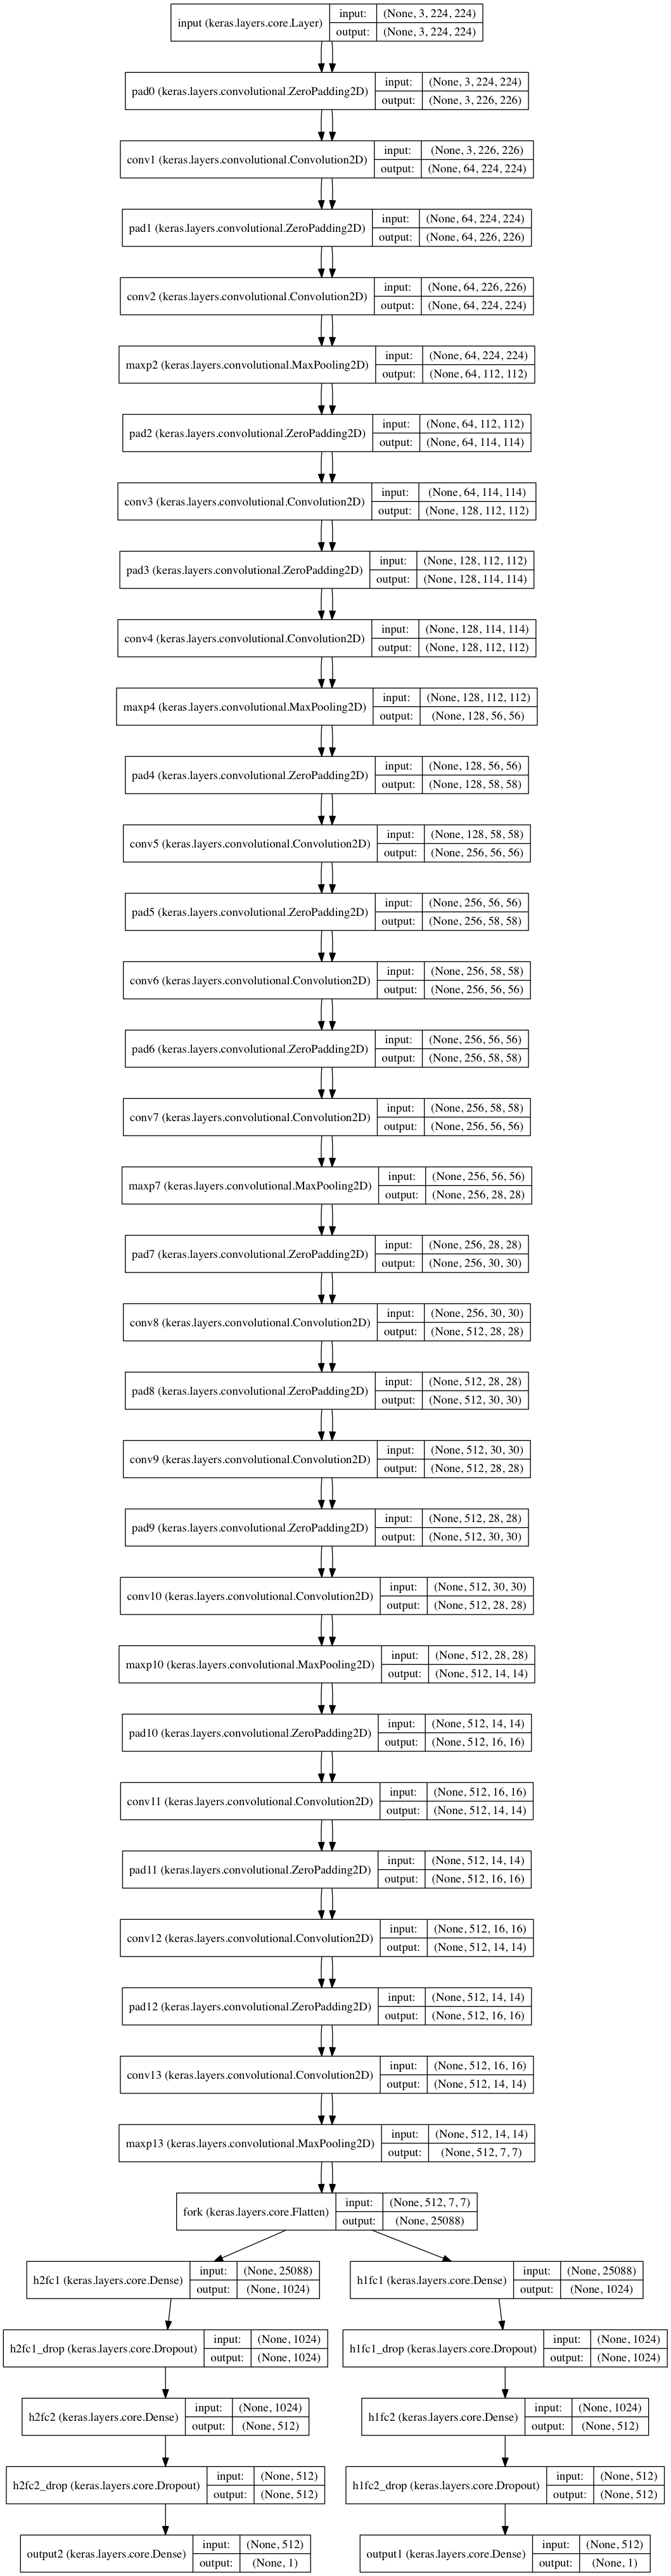

In [53]:
# display graph
plot(yelp_model, to_file='graph.png', show_shape=True)
IPython.display.Image('./graph.png')

In [54]:
# transfer learning
conv_idx = 0
for i in range(9):
    if "conv" in vgg16_model.layers[i].name:
        conv_idx += 1
        conv_layer_name = "conv" + str(conv_idx)
        if conv_layer_name in yelp_model.namespace:
            print "Transfer vgg layer", i, "to yelp model conv", conv_idx
            yelp_model.nodes[conv_layer_name].W.set_value(vgg16_model.layers[i].get_weights()[0]);
            yelp_model.nodes[conv_layer_name].b.set_value(vgg16_model.layers[i].get_weights()[1]);

Transfer vgg layer 1 to yelp model conv 1
Transfer vgg layer 3 to yelp model conv 2
Transfer vgg layer 6 to yelp model conv 3
Transfer vgg layer 8 to yelp model conv 4


In [55]:
# freeze bottom layers
for node_name in yelp_model.nodes.keys():
    yelp_model.nodes[node_name].trainable = False
    if node_name == "conv4":
        break

In [379]:
sgd = SGD(lr=0.0005, decay=0.0, momentum=0.9, nesterov=True)
yelp_model.compile(optimizer=sgd, loss={'output1':'binary_crossentropy', 'output2':'binary_crossentropy'})

In [380]:
# cat1 vs cat2 "good_for_lunch" vs "good_for_dinner"
history = yelp_model.fit( 
            {'input':X_train, 'output1': y_train[:,:1], 'output2': y_train[:,:2]}, 
            batch_size=128, verbose=1, nb_epoch=10, validation_split=0.25)

In [152]:
# # visualize learned weights 

# w1 = yelp_model.nodes['conv7'].W
# # w1 = vgg16_model.layers[15].W
# w1.get_value().shape
# # N C H W 
# num_repr = len(w1.get_value())

# for i, w in enumerate(w1.get_value()):
#     plt.subplot(np.sqrt(num_repr)+1, np.sqrt(num_repr), i+1)
#     plt.imshow(w1.get_value()[i].transpose(1,2,0)[:,:,0], cmap="gray", interpolation='none')

In [147]:
predictions = yelp_model.predict({'input': X_test}, batch_size=128)

In [381]:
np.mean(y_test[:,1] == np_utils.categorical_probas_to_classes(predictions['output1']))

In [382]:
np.mean(y_test[:,2] == np_utils.categorical_probas_to_classes(predictions['output2']))